<font color="#CA3532" style="font-size:40px"><h1 align="left" >Data Augmentation</h1></font>
<font color="#CA3532" style="font-size:15px"><h1 align="left" >Técnicas y funciones</h1></font>
<font color="#6E6E6E"><h3 align="left">Jaen-Lorites, Jose Manuel</h3></font> 

En este documento se pretende explorar las técnicas y definir las funciones de Data Augmentation, de forma que podamos aumentar el tamaño de nuestro dataset.

*TODO:*
- Buscar en bibliografía cuanto es conveniente augmentar el dataset (n·cunanto)

In [1]:
import sys; sys.path.insert(0, '../Scripts')
# import load_images
from load_images import load_images, get_df_paths
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

import copy

Succesfull loaded: path_list, labels, split, image_type, file_npy
Succesfull loaded: df_metadata_images


A continuación tenemos la función empleada por Manu:

In [ ]:
def augment(images_train, labels_hot_encode_train, n):
    data_gen_args = dict(
                         rotation_range=30, zoom_range=0.05,
                         shear_range=20)
                         # width_shift_range=0.1,
                         # height_shift_range=0.1,
                         # zoom_range=0.2)
    image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    seed = 1
    image_datagen.fit(images_train, augment=True, seed=seed)
    mask_datagen.fit(labels_hot_encode_train, augment=True, seed=seed)
    matrix = np.empty(images_train.shape)
    matrix_mask = np.empty(labels_hot_encode_train.shape)
    iter = 1
    im_iter = image_datagen.flow(images_train, batch_size=1,seed=seed)
    mask_iter = image_datagen.flow(labels_hot_encode_train, batch_size=1,seed=seed)
    images_train_up = copy.deepcopy(images_train)
    labels_hot_encode_train_up = copy.deepcopy(labels_hot_encode_train)
    while iter<=n:
        for i in range(images_train.shape[0]):
            matrix[i,:,:,:]= im_iter.next()
            matrix_mask[i, :, :, :] = mask_iter.next()
            print(i)
        matrix_mask[matrix_mask>=0.5] = 1
        matrix_mask[matrix_mask<0.5] = 0
        images_train_up = np.concatenate((images_train_up,matrix))
        labels_hot_encode_train_up = np.concatenate((labels_hot_encode_train_up,matrix_mask))
        iter = iter+1
    return  images_train_up, labels_hot_encode_train_up

Utiliza ImageDateGenerator (<a href='https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator'>Revisar documentación</a>)

- `flow()` genera un iterador en el cual se generan imagenes
- `copy.deepcopy()` Revisar <a href='https://docs.python.org/3/library/copy.html#copy.deepcopy'>documentación</a>. Creo que la clave es que crea una copia de la lista, donde sus elementos no son referencias a los elementos de la original, sino que también se realizan copias de estos. Tal vez trabajando directamente con *np.array* no sea necesario.

### Realizamos algunas pruebas

In [26]:
# Cargamos Data
n_train = 30
n_valid = 5
X_train = load_images(get_df_paths(n=n_train))
X_valid = load_images(get_df_paths(n=n_valid))

In [27]:
data_gen_args = dict(
                     rotation_range=10, zoom_range=0.05,
                     shear_range=10)
                     # width_shift_range=0.1,
                     # height_shift_range=0.1,
                     # zoom_range=0.2)
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
# image_datagen.fit(X_valid[:,:,:,np.newaxis], augment=True, seed=1) #Creo que en nuestro caso no es necesrio
im_iter = image_datagen.flow(X_valid[:,:,:,np.newaxis], batch_size=1,seed=1)

In [28]:
im_iter.next().shape

(1, 180, 180, 1)

In [2]:
def generador():
#         i=0
#         while True:
        yield im_iter.next()[0,:,:,:], im_iter.next()[0,:,:,:]
    
ds = tf.data.Dataset.from_generator(
    generador, 
    output_types=(tf.float64,tf.float64), 
    output_shapes=([180,180,1],[180,180,1])
)

# ds.as_numpy_iterator().next()

In [96]:
dataset = tf.data.Dataset.from_tensor_slices(X_valid[:,:,:,np.newaxis])
len(list(dataset.concatenate(ds.take(2)).as_numpy_iterator()))
# len(list(ds.take(2).as_numpy_iterator()))
# dataset.element_spec

551

### Discusión y resumen de lo aprendido:

Tras realizar diferentes pruebas con las funciones de `tf`, y apoyandome tanto en el código de Manu como en la documentación de `tf` (<a href=https://www.tensorflow.org/guide/data>Canalizaciones entrada de datos</a>, <a href=https://www.tensorflow.org/api_docs/python/tf/data/Dataset>tf.data.Dataset</a>), encuentro que:    
- Keras acepta como input objetos de tipo Dataset.    
- Se puede generar un objeto Dataset a partir de un iterador.    
- Se puede generar un objeto Dataset a partir de un np.array.    
- Se pueden concatenar objetos Dataset, formando un nuevo objeto Dataset que incluya a ambos.  

Es por ello que veo útil la creación de una función que me genere un objeto del tipo Dataset que incluya tanto las imágenes reales, como las de DataAugmentation:

**TODO:** El posterior modelo necesita que el elemento "y" lo proporcione también el dataset. Revisar eso y modificar la función como sea necesario. es decir, el objeto Dataset deberá generar, para el autoencoder, (image, image).

In [41]:
def gen_data(n_train, n_gen, data_gen_args, n_val):
    
    ims = load_images(get_df_paths(n=10, random=False)) # Cargamos las imagenes reales
    '''Revisar este punto. Tarda mucho en cargar dataset. Valorar crear pickle.'''
    print("ims cargadas")
    
    n_ims = ims.shape[0]
    if n_train<=1 & isinstance(n_train, float): #asumimos n_float como fracción
        n_train = int(np.round(n_ims*n_train))
    
    ims_train = ims[:n_train, :, :]
    ims_val = ims[n_train:, :, :]
    
    # Generamos el DS de train. newaxis por posterior requerimiento de DataAugmentation
    ds_train = tf.data.Dataset.from_tensor_slices((ims_train[:,np.newaxis,:,:,np.newaxis],ims_train[:,np.newaxis,:,:,np.newaxis]))
    ds_val = tf.data.Dataset.from_tensor_slices((ims_val[:,np.newaxis,:,:,np.newaxis], ims_val[:,np.newaxis,:,:,np.newaxis]))
    print("ds_train y ds_val generados")
    
    # Generamos DS de DataAugmentation
    image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    im_iter = image_datagen.flow(ims_train[:,:,:,np.newaxis], batch_size=1, seed=1) # Iterador/Generador
    # TODO: Revisar batch_size y ims/ims_train
    def generador():
        aux_iter = im_iter.next()
        yield aux_iter, aux_iter
        
    ds_gen = tf.data.Dataset.from_generator(generador, output_types=(tf.float64, tf.float64), 
                                             output_shapes=([1,180,180,1], [1,180,180,1]))
    
    # SOME ARGUMENTS ARE DEPRECATED: (output_shapes, output_types). They will be removed in a future version. 
                                        #Instructions for updating: Use output_signature instead (no esta en esta version)
#     ds_gen = tf.data.Dataset.from_generator(lambda: im_iter, 
#                                         output_signature=tf.TensorSpec(shape=(1,180,180,1), dtype=tf.float64))
    print("ds_gen generado")
    # Concatenamos ds_train y ds_gen, indicando cuantas imágenes se generan
    ds = ds_train.concatenate(ds_gen.take(n_gen))
    print("ds concatenado")
#     ds = ds.shuffle(n_train+n_gen, reshuffle_each_iteration=True) 
    '''Revisar 1er argumento si problemas con la memoria'''
    return(ds, ds_val)

In [42]:
data_gen_args = dict(
                     rotation_range=10, zoom_range=0.05,
                     shear_range=10)
                     # width_shift_range=0.1,
                     # height_shift_range=0.1,
                     # zoom_range=0.2)
            
ds,ds_val = gen_data(0.9, 20, data_gen_args, 10)
a=ds_val.as_numpy_iterator().next()

ims cargadas
ds_train y ds_val generados
ds_gen generado
ds concatenado


In [20]:
len(a)

2

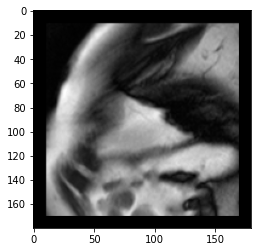

In [21]:
plt.imshow(a[0][:,:,0])

In [22]:
a[1].shape

(180, 180, 1)

In [34]:
ds.as_numpy_iterator().next()[0].shape

(1, 180, 180, 1)

In [43]:
ds

<ConcatenateDataset shapes: ((1, 180, 180, 1), (1, 180, 180, 1)), types: (tf.float64, tf.float64)>